In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json

In [2]:
import psycopg2
from sqlalchemy import create_engine
# set the variables for the pull from SQL.  username and password are in an .env file.  You will need those to make this run
# on your machine.
host = 'localhost'
port = 5432
dbname='PatentsXmls'
username = 'postgres'
pwd = 'postgres'

# set up the connection to the database "ETL_Project"
connection_string = f'{username}:{pwd}@{host}:{port}/{dbname}'
engine = create_engine(f'postgresql://{connection_string}')

# ETL Patents Documents

* DataBase = PatentsXmls
* Table names = f'PatentsDoc{year}'

In [3]:
# read csv files and load tables to PostgreSQL
ptCols = ['filename', 'publication-No', 'publication-date',
       'PCT-No', 'PCT-date',
       'priority-country',
       'applicant1-name', 'applicant1-country',
       'agent-name',
       'agent-country']
# for year in range(2000,2021):
#     print(year)
#     # extract
#     patentsDF = pd.read_csv(f'{out_dir}/documentsAll-{year}.csv')
#     # transform
#     pDF = patentsDF[ptCols].astype('str')
#     names = pDF['applicant1-name']
#     pDF['applicant1-name'] = names.mask(names.str.len()>200, names.str.slice(stop=200))
#     names = pDF['agent-name']
#     pDF['agent-name'] = names.mask(names.str.len()>200, names.str.slice(stop=200))
#     # load
#     tbName = f'PatentsDoc{year}'
#     pDF.to_sql(name=tbName, con=engine, if_exists='append', index=False)

# Statistics of Patent documents

* count publications by country, year
* count agents by country, year

### Adding applicants

* Some publications don't have applicants info in English.
* They were excluded, resulting in None in applicant-fields in tables of PatentsXmls DB
* The following extracts applicants info from thosse xml files and save them into each year json file
  where are located in '../PatentXmlParsing/output_csv_files/{year}/applicants-other-{year}.json'

In [4]:
# from xml_parsing import getPartyInfo2, readInventorCountry, readApplicants

# out_path = '../PatentXmlParsing/output_csv_files'
# # find country from xmlafile and save
# def getInvCountry(year, fileDF):
#     # find inventor country
#     country = []
#     for vl in fileDF.values:
#         # vl = ['filename', 'publication-No']
#         country.append([vl[0], vl[1], readInventorCountry(vl[0])])
        
#     cDF = pd.DataFrame(data=np.array(country), columns=['filename', 'publication-No', 'country'])
#     cDF.to_csv(f"{out_path}/{year}/inventor-countries-{year}.csv", index=False)
#     #return cDF
    
# # find applicants from xmlfile, of which lang is neither 'en' nor 'ko'
# def getApplicantsOther(year, fileDF):
#     applicantsDT = []
#     for vl in fileDF.values:
#         # vl = ['filename', 'publication-No']                
#         # applicants
#         applicantsDT.append(readApplicants(vl[0]))
        
#     with open(f'{out_path}/{year}/applicants-other-{year}.json', 'w') as fp:
#         json.dump(applicantsDT, fp)
        
        
# # handle the publications which applicant-country == None
# for year in range(2001,2022):
#     sql_query = f"""
#         SELECT "filename", "publication-No"
#         FROM "PatentsDoc{year}"
#         WHERE "applicant1-country" = 'None';
#     """
#     pDF = pd.read_sql_query(sql_query, con=engine)
#     getApplicantsOther(year, pDF)

## The number of patent publications by country

In [150]:
def extractApplicantCountry(jsonData):
    # each dict in jsonData list is an applicants-info from a patent doc
    countries = []
    filenames = []
    for pt in jsonData:
        filenames.append(pt.get('filename'))
        if pt.get('other'):
            cntry = pt.get('other')[0].get('country') if len(pt.get('other')) else 'None'
        else:
            cntry = 'None'
        countries.append(cntry)
    # return the counts by country
    appDF = pd.DataFrame({'country' : countries, 'filename': filenames})    
    return appDF.groupby('country').count().rename(columns={'filename':'count_non_en'})


topCountries= {
   "name": {
      "AT": "Austria",
      "AU": "Australia",
      "BE": "Belgium",
      "CA": "Canada",
      "CH": "Switzerland",
      "CN": "China",
      "DE": "Germany",
      "DK": "Denmark",
      "ES": "Spain",
      "FI": "Finland",
      "FR": "France",
      "GB": "United Kingdom",
      "IL": "Israel",
      "IN": "India",
      "IT": "Italy",
      "JP": "Japan",
      "KR": "South Korea",
      "NL": "Netherlands",
      "NO": "Norway",
      "RU": "Russia",
      "SE": "Sweden",
      "SG": "Singapore",
      "TR": "Turkey",
      "US": "United States"
   },
   "color": {
      "AT": "#000080",
      "AU": "#006400",
      "BE": "#20B2AA",
      "CA": "#800000",
      "CH": "#C71585",
      "CN": "#FF0000",
      "DE": "#4B0082",
      "DK": "#00FFFF",
      "ES": "#FF69B4",
      "FI": "#87CEEB",
      "FR": "#F08080",
      "GB": "#FFD700",
      "IL": "#FFA500",
      "IN": "#FFFF00",
      "IT": "#008B8B",
      "JP": "#FF4500",
      "KR": "#0000FF",
      "NL": "#8A2BE2",
      "NO": "#483D8B",
      "RU": "#708090",
      "SE": "#EE82EE",
      "SG": "#FA8072",
      "TR": "#556B2F",
      "US": "#800080"
   }
}


In [82]:
# count the publications by country (applicants' country)
appAllDF = pd.DataFrame()
for year in range(2000,2022):
    
    # count the publications which have applicants info in 'en'
    sql_query = f"""
        SELECT doc."applicant1-country" country, COUNT(doc."publication-No")
        FROM "PatentsDoc{year}" doc
        WHERE "applicant1-country" != 'None'
        GROUP BY "applicant1-country";
    """
    apDF = pd.read_sql_query(sql_query, con=engine)
    
    # count the publications which have applicants info not in 'en'
    infofiles_dir = f'../PatentXmlParsing/output_csv_files/{year}'
    with open(f'{infofiles_dir}/applicants-other-{year}.json', 'r') as fp:
         jsonData = json.load(fp)
    apNenDF = extractApplicantCountry(jsonData)
    
    # merge two DF in one count of the year
    aplcntDF = apDF.merge(apNenDF, on='country', how='outer').fillna(0)
    aplcntDF[year] = aplcntDF['count'] + aplcntDF['count_non_en']
    
    # combine this year info to all-year info
    if appAllDF.empty:
        appAllDF = aplcntDF[['country', year]]
    else:
        appAllDF = appAllDF.merge(aplcntDF[['country', year]], on='country', how='outer')

appAllDF.fillna(0, inplace=True)

In [119]:
# save the final result to js file
jsondt = appAllDF.to_dict('dict')
with open('static/js/countsByApplicantCountry.json', 'w') as fp:
    json.dump(jsondt, fp, indent=3)

In [83]:
appAllDF.columns

Index(['country',      2000,      2001,      2002,      2003,      2004,
            2005,      2006,      2007,      2008,      2009,      2010,
            2011,      2012,      2013,      2014,      2015,      2016,
            2017,      2018,      2019,      2020,      2021],
      dtype='object')

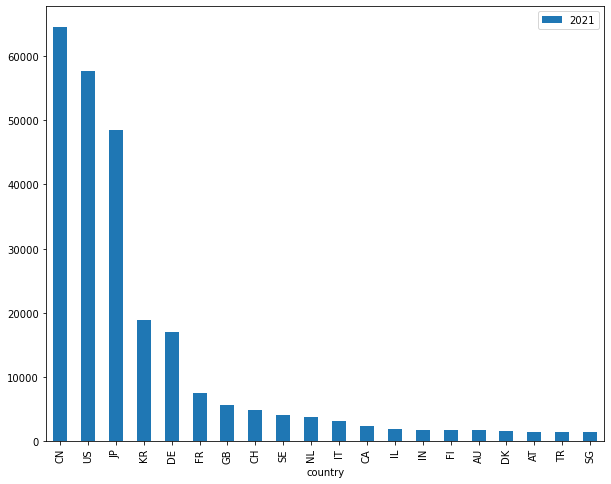

In [97]:
aDF21 = appAllDF.sort_values(by=[2021], ascending=False).set_index('country')
with open('static/js/countsSortBy2021.js', 'w') as fp:
    json.dump(aDF21.head(20).to_dict('dict'), fp, indent=3)
    
fig = aDF21.head(20).plot.bar(use_index=True, y=2021, figsize=(10, 8))

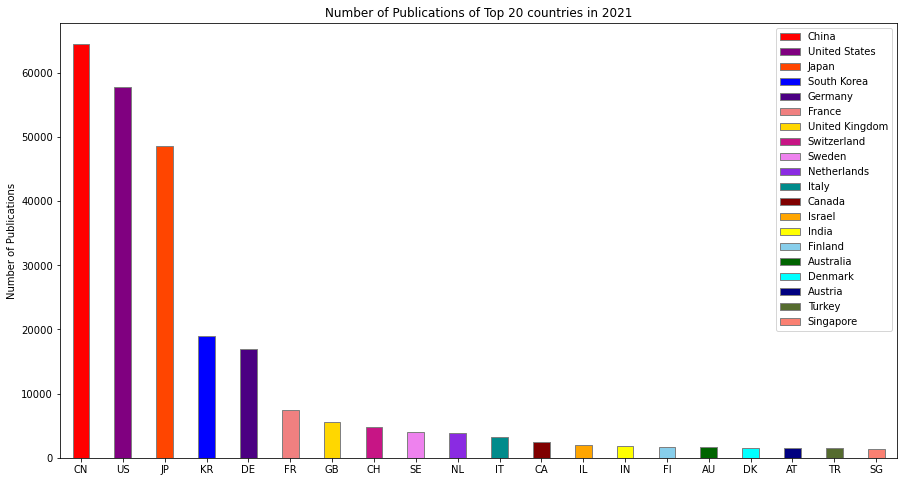

In [176]:
# ax.set_title(f"Number of wins about the attendance range - {L_names[league]}", fontsize=font_s["t"])
n = 20
aTopDF21 = aDF21[2021].head(n)
xticks = list(aTopDF21.index)
colors = [ topCountries['color'][ct] for ct in xticks ]
names = [ topCountries['name'][ct] for ct in xticks ]
x = np.arange(n)
w = 0.4
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title("Number of Publications of Top 20 countries in 2021")
for i, ct in enumerate(xticks):
    ax.bar( i, aTopDF21.loc[ct], color=colors[i], edgecolor = 'gray', width=w, label = names[i])
ax.set_xticks(x, labels=xticks, rotation=0)
ax.set_xlim(-0.5, n-0.5)
ax.set_ylabel("Number of Publications")
ax.legend()
fig.savefig("images/top20_2021.png", bbox_inches='tight')
plt.show()

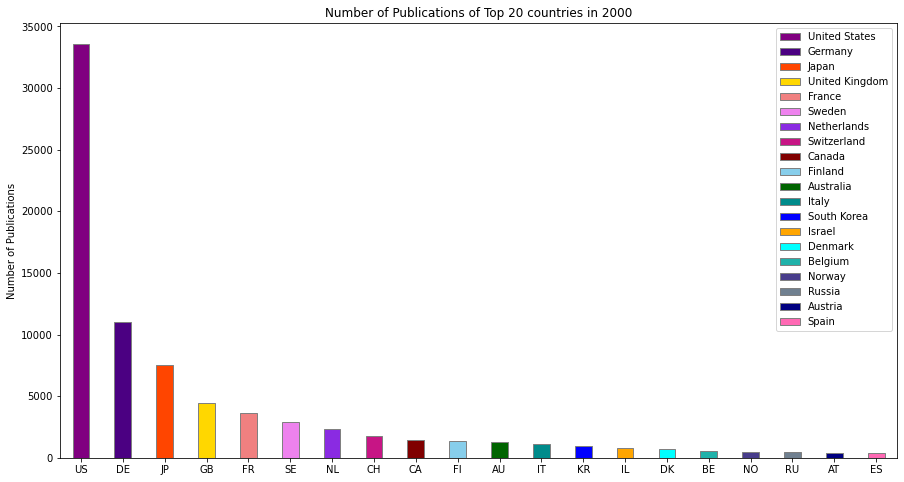

In [191]:
n = 20
aTopDF00 = appAllDF.sort_values(by=[2000], ascending=False).set_index('country')[2000].head(n)
xticks = list(aTopDF00.index)
colors = [ topCountries['color'][ct] for ct in xticks ]
names = [ topCountries['name'][ct] for ct in xticks ]
x = np.arange(n)
w = 0.4
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title("Number of Publications of Top 20 countries in 2000")
for i, ct in enumerate(xticks):
    ax.bar( i, aTopDF00.loc[ct], color=colors[i], edgecolor = 'gray', width=w, label = names[i])
ax.set_xticks(x, labels=xticks, rotation=0)
ax.set_xlim(-0.5, n-0.5)
ax.set_ylabel("Number of Publications")
ax.legend()
fig.savefig(f"images/top20_2000.png", bbox_inches='tight')
plt.show()

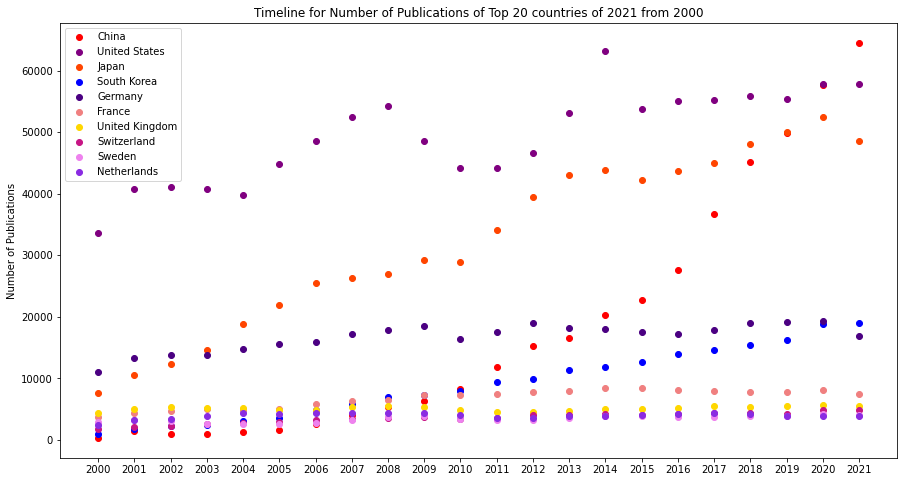

In [190]:
n = 10
aTopDF = appAllDF.sort_values(by=[2021], ascending=False).set_index('country').head(n).T
topCt = list(aTopDF.columns)
colors = [ topCountries['color'][ct] for ct in topCt ]
names = [ topCountries['name'][ct] for ct in topCt ]
x = aTopDF.index # 2000 ~ 2021
w = 0.4
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title("Timeline for Number of Publications of Top 20 countries of 2021 from 2000")
for i, ct in enumerate(topCt):
    ax.scatter( x, aTopDF[ct], color=colors[i], label = names[i])
ax.set_xticks(x, labels=x, rotation=0)
# ax.set_xlim(-0.5, n-0.5)
ax.set_ylabel("Number of Publications")
ax.legend()
fig.savefig(f"images/top20_2000.png", bbox_inches='tight')
plt.show()

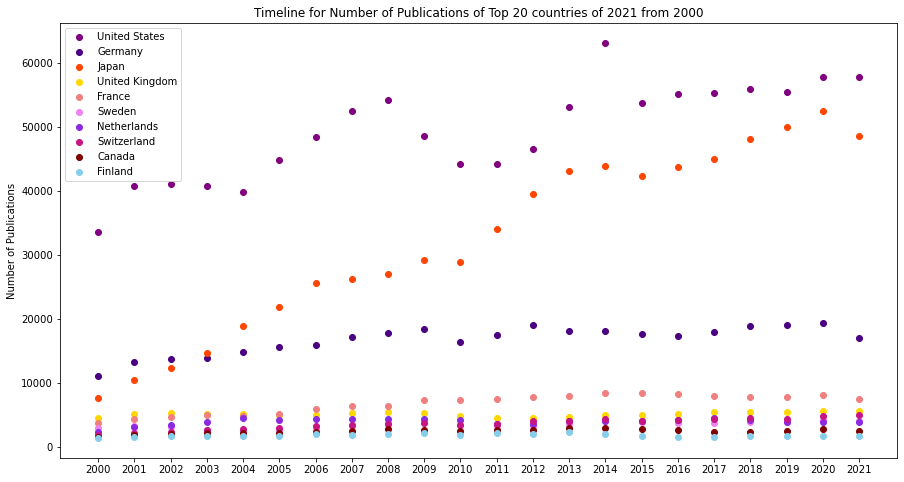

In [189]:
n = 10
aTopDF = appAllDF.sort_values(by=[2000], ascending=False).set_index('country').head(n).T
topCt = list(aTopDF.columns)
colors = [ topCountries['color'][ct] for ct in topCt ]
names = [ topCountries['name'][ct] for ct in topCt ]
x = aTopDF.index # 2000 ~ 2021
w = 0.4
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title("Timeline for Number of Publications of Top 20 countries of 2021 from 2000")
for i, ct in enumerate(topCt):
    ax.scatter( x, aTopDF[ct], color=colors[i], label = names[i])
ax.set_xticks(x, labels=x, rotation=0)
# ax.set_xlim(-0.5, n-0.5)
ax.set_ylabel("Number of Publications")
ax.legend()
fig.savefig(f"images/top20_2000.png", bbox_inches='tight')
plt.show()

In [121]:
countryNames = pd.read_csv('static/countries.csv')
names = []
countryNames.set_index('country', inplace=True)
for country in top20countries:
    #print(country, countryNames.at[country, 'name'])
    names.append(countryNames.at[country, 'name'])
with open('static/countryNames.js', 'w') as fp:
    json.dump({'country':list(top20countries), 'name': names}, fp, indent=3)
#contry20Names=pd.DataFrame({'country':top20countries, 'name': names})

In [127]:
contry20Names=pd.DataFrame({'country':top20countries, 'name': names})

with open('static/countryNames.js', 'w') as fp:
    json.dump(contry20Names.set_index('country').to_dict('dict'), fp, indent=3)

#### The publications of '--' in country field
**** In counting above, the publicaions which has country as '--' are as follows.

In [56]:
dashedAllDF = pd.DataFrame()
for year in range(2000, 2022):
    # count the publicaitons which app-country == '--'
    sql_query = f"""
        SELECT doc."priority-country" country, COUNT(doc."publication-No")
        FROM "PatentsDoc{year}" doc
        WHERE "applicant1-country" = '--'
        GROUP BY "priority-country";
    """
    dashedDF = pd.read_sql_query(sql_query, con=engine)
    dashedDF.rename(columns={'count':year}, inplace=True)
    # combine this year info to all-year info
    if dashedAllDF.empty:
        dashedAllDF = dashedDF.copy()
    else:
        dashedAllDF = dashedAllDF.merge(dashedDF, on='country', how='outer')
        
dashedAllDF

,country,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,US,1.0,2.0,1.0,NaN,2.0,4.0,1.0,1.0,2.0,1.0,2.0,7.0
1,GB,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NZ,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EP,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
5,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
6,SE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN


### Number of priority countries

In [109]:
# init DataFrame with 2000 data
year = 2000
sql_query = f"""
    SELECT doc."priority-country" country, COUNT(doc."publication-No")
    FROM "PatentsDoc{year}" doc
    GROUP BY "priority-country";
"""
countryDF = pd.read_sql_query(sql_query, con=engine)
countryDF.rename(columns={'count': f'{year}'}, inplace=True)

# extract counts for 2001~2021
for year in range(2001,2022):
    sql_query = f"""
        SELECT doc."priority-country", COUNT(doc."publication-No")
        FROM "PatentsDoc{year}" doc
        GROUP BY "priority-country";
    """
    cDF = pd.read_sql_query(sql_query, con=engine)
    countryDF = countryDF.merge(cDF, on='country', how='outer')
    countryDF.rename(columns={'count': f'{year}'}, inplace=True)

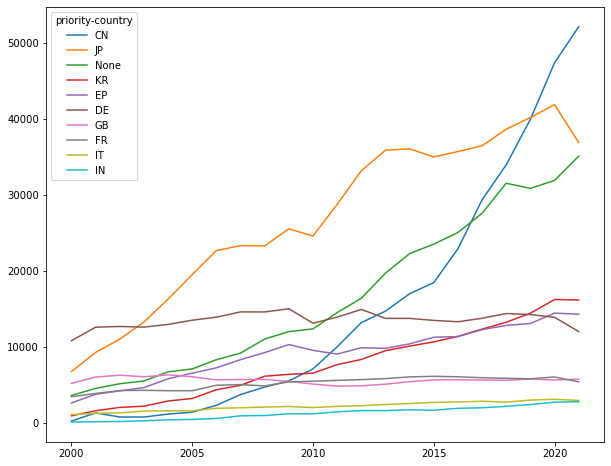

In [161]:
cDF21 = countryDF.sort_values(by='2021', ascending=False).set_index('priority-country')
fig = cDF21.drop(['US']).head(10).T.plot(use_index=True, figsize=(10, 8))

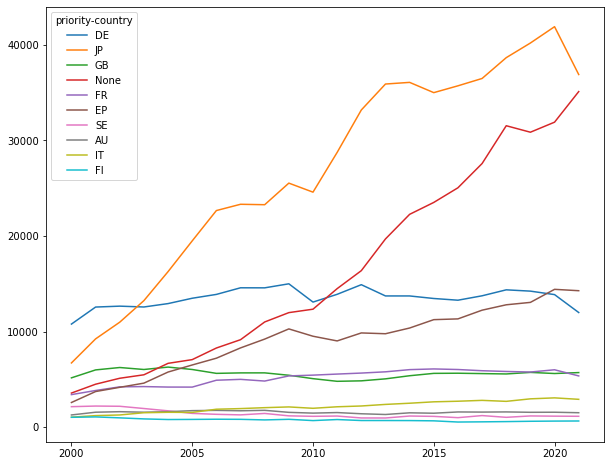

In [147]:
cDF00 = countryDF.sort_values(by='2000', ascending=False).set_index('priority-country').drop(['US']).head(10)
fig = cDF00.head(10).T.plot(use_index=True, figsize=(10, 8))

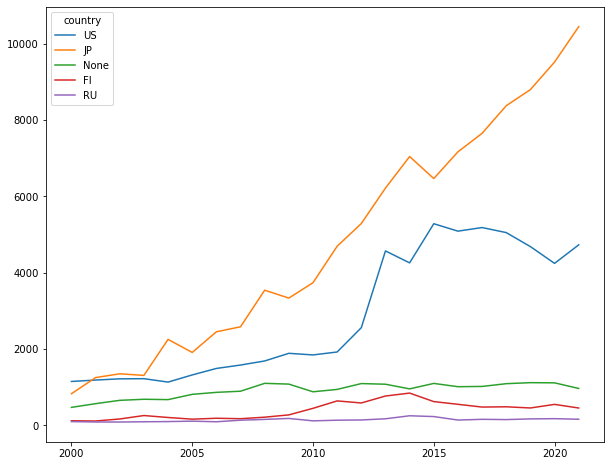

In [145]:
nDF00 = nonDF.sort_values(by='2000', ascending=False).set_index('country').head(10)
fig = nDF00.head(5).T.plot(use_index=True, figsize=(10, 8))

In [150]:
patentsDF = pd.read_csv(f'{out_dir}/documentsAll-2021.csv')

In [155]:
patentsDF.columns

Index(['Unnamed: 0', 'filename', 'publication-No', 'publication-date',
       'PCT-No', 'PCT-date', 'IPC', 'priority-No', 'priority-date',
       'priority-country', 'applicant1-name', 'applicant1-address',
       'applicant1-postcode', 'applicant1-country', 'applicant1-name-KR',
       'applicant1-address-KR', 'applicant2-name', 'applicant2-address',
       'applicant2-postcode', 'applicant2-country', 'applicant2-name-KR',
       'applicant2-address-KR', 'applicant3-name', 'applicant3-address',
       'applicant3-postcode', 'applicant3-country', 'applicant3-name-KR',
       'applicant3-address-KR', 'Inventors', 'agent-name', 'agent-address',
       'agent-country', 'agent-postcode', 'agent-name-KR', 'agent-address-KR',
       'title-EN', 'abstract-EN'],
      dtype='object')

In [159]:
patentsDF.loc[(patentsDF['applicant1-country']=='None') & (patentsDF['priority-country']=='None')][['filename', 'Inventors']].head(30)

,filename,Inventors
325,2021-21-92-00.xml,"BACHMAIER, Georg, BACHMANN, Christian, BERGMAN..."
337,2021-21-92-13.xml,"LAUN, Rober"
342,2021-21-92-10.xml,"LAUN, Rober"
360,2021-21-92-18.xml,None
3235,2021-21-45-06.xml,"RODRÍGUEZ GUZMÁN, Ernesto, Abelard"
4293,2021-21-21-90.xml,None
4298,2021-21-21-91.xml,None
4652,2021-21-72-23.xml,"ALVAREZ FASANO, Antonio Carlo"
4687,2021-21-72-79.xml,"SWETT BROWNE, Cristian Enriqu"
4811,2021-21-43-49.xml,"RUIZ, Luis Antoni"


In [155]:
mergedDF = agentsCountDF.merge(countries, how='inner', on='country' )
mergedDF.head()

,country,counts,latitude,longitude,name
0,US,221968,37.090240,-95.712891,United States
1,JP,83816,36.204824,138.252924,Japan
2,CN,63288,35.861660,104.195397,China
3,IT,21448,41.871940,12.567380,Italy
4,KR,21247,35.907757,127.766922,South Korea


In [157]:
# Set the countries' locations with Lattitude and Longitude
locations = mergedDF[['latitude', 'longitude']]
# Set the weights as the counts of the names
counts = mergedDF['counts']

# Creat the base map centered with the US coordinate
US_coord = (37.09024, -95.712891)
wfig = gmaps.figure(center=US_coord, zoom_level=2)

# Set the heat layer
heat_layer = gmaps.heatmap_layer(locations=locations, weights=counts,
                                dissipating=False, max_intensity=10,
                                point_radius=1)

# Add the layer
wfig.add_layer(heat_layer)

# Show the gmap
wfig

Figure(layout=FigureLayout(height='420px'))

In [161]:
import gmaps

gmaps.configure(api_key=g_key)
fig = gmaps.figure()
fig

Figure(layout=FigureLayout(height='420px'))

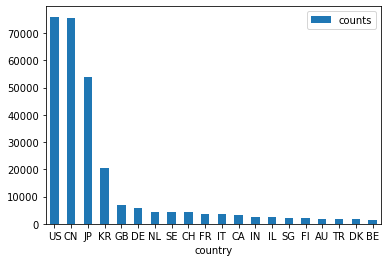

In [134]:
agntbarplot = agentsCountDF.head(20).plot(x='country', y='counts', kind='bar', rot=0)
plt.savefig('images/agentsCountriesStat.png')

In [135]:
agentsKR = agentsDF.loc[agentsDF['country'] == 'KR']
agentsKR.shape

(20553, 7)

In [136]:
agentsKRcount = agentsKR.groupby('name').count().sort_values(by='type',ascending=False)['type'].head(20)
agentsKRcount.sum()

9302

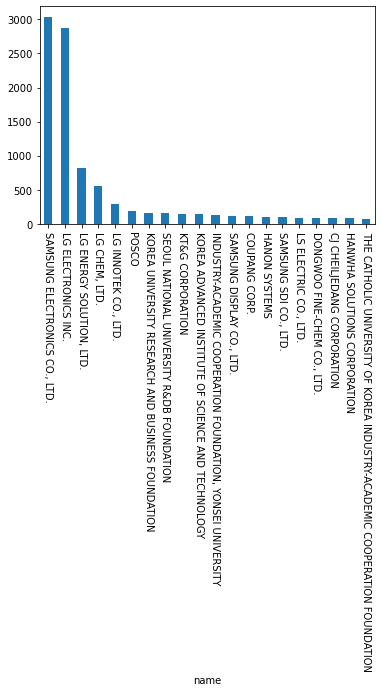

In [137]:
plot = agentsKRcount.plot.bar(x='name', y='type', rot=270)
plt.savefig('images/agentsKRtop20.png')

## Save countries' latitutde and longitude

In [38]:
# Read countries.txt and convert it to dataframe and save it to csvfile

with open('static/countries.txt', 'r') as fp:
    cdata = fp.read()

cLines = cdata.split('\n')
cInfos = []
for cline in cLines:
    cInfos.append(cline.split("\t"))
    
countriesGeo = pd.DataFrame(np.array(cInfos[1:]), columns = cInfos[0])
countriesGeo.head(10)
countriesGeo.to_csv("static/countries.csv", index=False)